In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)

# Cross-validation
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("="*80)
print("FRAUD DETECTION - MODEL TRAINING")
print("="*80)
print("\n✓ All libraries imported successfully!")

FRAUD DETECTION - MODEL TRAINING

✓ All libraries imported successfully!


In [2]:
print("="*80)
print("LOADING PREPROCESSED DATA")
print("="*80)

# Load the preprocessed data
X_train_full = np.load('../data/preprocessed/X_train_full.npy')
y_train_full = np.load('../data/preprocessed/y_train_full.npy')
X_test = np.load('../data/preprocessed/X_test.npy')
X_test_scaled = np.load('../data/preprocessed/X_test_scaled.npy')
y_test = np.load('../data/preprocessed/y_test.npy')

# Load preprocessing parameters
params = joblib.load('../data/preprocessed/preprocessing_params.pkl')
scaler = joblib.load('../data/preprocessed/scaler.pkl')

# Load feature names
with open('../data/preprocessed/feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print("✓ Data loaded successfully!")
print(f"\nTraining data shape: {X_train_full.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"\nPreprocessing parameters:")
for key, value in params.items():
    if key != 'feature_names':  # Skip feature names list (too long)
        print(f"  • {key}: {value}")

print(f"\nTraining set fraud distribution:")
print(f"  Non-Fraud: {(y_train_full == 0).sum():,}")
print(f"  Fraud: {(y_train_full == 1).sum():,}")
print(f"  Fraud rate: {y_train_full.mean()*100:.2f}%")

print(f"\nTest set fraud distribution:")
print(f"  Non-Fraud: {(y_test == 0).sum():,}")
print(f"  Fraud: {(y_test == 1).sum():,}")
print(f"  Fraud rate: {y_test.mean()*100:.2f}%")

LOADING PREPROCESSED DATA
✓ Data loaded successfully!

Training data shape: (160000, 54)
Test data shape: (40000, 54)
Number of features: 54

Preprocessing parameters:
  • n_folds: 5
  • test_size: 0.2
  • random_state: 42
  • smote_strategy: 0.5
  • total_features: 54

Training set fraud distribution:
  Non-Fraud: 151,930
  Fraud: 8,070
  Fraud rate: 5.04%

Test set fraud distribution:
  Non-Fraud: 37,982
  Fraud: 2,018
  Fraud rate: 5.04%


In [3]:
print("="*80)
print("K-FOLD CROSS-VALIDATION PIPELINE")
print("="*80)

def evaluate_model_kfold(model, model_name, X, y, n_splits=5, apply_smote=True, smote_strategy=0.5):
    """
    Evaluate model using Stratified K-Fold Cross-Validation with SMOTE
    
    Parameters:
    -----------
    model : sklearn model
        The model to evaluate
    model_name : str
        Name of the model for display
    X : array
        Feature matrix
    y : array
        Target vector
    n_splits : int
        Number of folds (default: 5)
    apply_smote : bool
        Whether to apply SMOTE (default: True)
    smote_strategy : float
        SMOTE sampling strategy (default: 0.5)
    
    Returns:
    --------
    results : dict
        Dictionary containing all metrics
    """
    
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*80}")
    
    # Initialize K-Fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Store results for each fold
    fold_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': []
    }
    
    # Train and evaluate on each fold
    start_time = time.time()
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold_idx}/{n_splits}...", end=" ")
        
        # Split data
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Scale features
        scaler_fold = StandardScaler()
        X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler_fold.transform(X_val_fold)
        
        # Apply SMOTE to training data only
        if apply_smote:
            smote = SMOTE(random_state=42, sampling_strategy=smote_strategy)
            X_train_fold_scaled, y_train_fold = smote.fit_resample(X_train_fold_scaled, y_train_fold)
        
        # Train model
        model.fit(X_train_fold_scaled, y_train_fold)
        
        # Predict on validation fold
        y_pred = model.predict(X_val_fold_scaled)
        y_pred_proba = model.predict_proba(X_val_fold_scaled)[:, 1]
        
        # Calculate metrics
        fold_results['accuracy'].append(accuracy_score(y_val_fold, y_pred))
        fold_results['precision'].append(precision_score(y_val_fold, y_pred))
        fold_results['recall'].append(recall_score(y_val_fold, y_pred))
        fold_results['f1'].append(f1_score(y_val_fold, y_pred))
        fold_results['roc_auc'].append(roc_auc_score(y_val_fold, y_pred_proba))
        
        print(f"F1: {fold_results['f1'][-1]:.4f}, Recall: {fold_results['recall'][-1]:.4f}")
    
    training_time = time.time() - start_time
    
    # Calculate average metrics
    print(f"\n{'='*80}")
    print(f"CROSS-VALIDATION RESULTS - {model_name}")
    print(f"{'='*80}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"\nAverage Metrics (across {n_splits} folds):")
    print(f"  Accuracy:  {np.mean(fold_results['accuracy']):.4f} ± {np.std(fold_results['accuracy']):.4f}")
    print(f"  Precision: {np.mean(fold_results['precision']):.4f} ± {np.std(fold_results['precision']):.4f}")
    print(f"  Recall:    {np.mean(fold_results['recall']):.4f} ± {np.std(fold_results['recall']):.4f}")
    print(f"  F1-Score:  {np.mean(fold_results['f1']):.4f} ± {np.std(fold_results['f1']):.4f}")
    print(f"  ROC-AUC:   {np.mean(fold_results['roc_auc']):.4f} ± {np.std(fold_results['roc_auc']):.4f}")
    
    # Return results
    results = {
        'model_name': model_name,
        'fold_results': fold_results,
        'avg_accuracy': np.mean(fold_results['accuracy']),
        'avg_precision': np.mean(fold_results['precision']),
        'avg_recall': np.mean(fold_results['recall']),
        'avg_f1': np.mean(fold_results['f1']),
        'avg_roc_auc': np.mean(fold_results['roc_auc']),
        'training_time': training_time
    }
    
    return results

print("✓ K-Fold CV pipeline function created!")
print("\nThis function will:")
print("  1. Split data into 5 folds (stratified)")
print("  2. For each fold:")
print("     • Scale features")
print("     • Apply SMOTE to training data")
print("     • Train model")
print("     • Evaluate on validation fold")
print("  3. Return average metrics across all folds")

K-FOLD CROSS-VALIDATION PIPELINE
✓ K-Fold CV pipeline function created!

This function will:
  1. Split data into 5 folds (stratified)
  2. For each fold:
     • Scale features
     • Apply SMOTE to training data
     • Train model
     • Evaluate on validation fold
  3. Return average metrics across all folds


In [4]:
print("="*80)
print("MODEL 1: LOGISTIC REGRESSION (BASELINE)")
print("="*80)

# Initialize Logistic Regression
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1  # Use all CPU cores
)

print("Model parameters:")
print(f"  • max_iter: 1000")
print(f"  • class_weight: balanced (helps with imbalanced data)")
print(f"  • solver: lbfgs (default)")

# Train and evaluate using K-Fold CV
lr_results = evaluate_model_kfold(
    model=lr_model,
    model_name="Logistic Regression",
    X=X_train_full,
    y=y_train_full,
    n_splits=5,
    apply_smote=True,
    smote_strategy=0.5
)

# Store results for later comparison
all_results = [lr_results]

print(f"\n{'='*80}")
print("✓ Logistic Regression training complete!")
print(f"{'='*80}")

MODEL 1: LOGISTIC REGRESSION (BASELINE)
Model parameters:
  • max_iter: 1000
  • class_weight: balanced (helps with imbalanced data)
  • solver: lbfgs (default)

TRAINING: Logistic Regression

Fold 1/5... F1: 0.0923, Recall: 0.4665

Fold 2/5... F1: 0.0923, Recall: 0.4839

Fold 3/5... F1: 0.0873, Recall: 0.4418

Fold 4/5... F1: 0.0937, Recall: 0.4851

Fold 5/5... F1: 0.0910, Recall: 0.4622

CROSS-VALIDATION RESULTS - Logistic Regression
Training time: 7.41 seconds

Average Metrics (across 5 folds):
  Accuracy:  0.5305 ± 0.0063
  Precision: 0.0506 ± 0.0012
  Recall:    0.4679 ± 0.0159
  F1-Score:  0.0913 ± 0.0022
  ROC-AUC:   0.5026 ± 0.0078

✓ Logistic Regression training complete!


In [5]:
print("="*80)
print("MODEL 1: LOGISTIC REGRESSION - COMPARING STRATEGIES")
print("="*80)

# We'll test 3 strategies:
# 1. SMOTE only
# 2. Class weights only  
# 3. Both (what we just did - for comparison)

print("\nWe'll compare 3 approaches to handling class imbalance:")
print("  Strategy 1: SMOTE only (no class_weight)")
print("  Strategy 2: Class weights only (no SMOTE)")
print("  Strategy 3: Both SMOTE + class_weight (our previous attempt)")
print("\n" + "="*80)

# Strategy 1: SMOTE only
print("\n🔄 STRATEGY 1: SMOTE ONLY")
lr_model_smote = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight=None,  # No class weights
    n_jobs=-1
)

lr_results_smote = evaluate_model_kfold(
    model=lr_model_smote,
    model_name="Logistic Regression (SMOTE only)",
    X=X_train_full,
    y=y_train_full,
    n_splits=5,
    apply_smote=True,
    smote_strategy=0.5
)

MODEL 1: LOGISTIC REGRESSION - COMPARING STRATEGIES

We'll compare 3 approaches to handling class imbalance:
  Strategy 1: SMOTE only (no class_weight)
  Strategy 2: Class weights only (no SMOTE)
  Strategy 3: Both SMOTE + class_weight (our previous attempt)


🔄 STRATEGY 1: SMOTE ONLY

TRAINING: Logistic Regression (SMOTE only)

Fold 1/5... F1: 0.0000, Recall: 0.0000

Fold 2/5... F1: 0.0000, Recall: 0.0000

Fold 3/5... F1: 0.0012, Recall: 0.0006

Fold 4/5... F1: 0.0000, Recall: 0.0000

Fold 5/5... F1: 0.0000, Recall: 0.0000

CROSS-VALIDATION RESULTS - Logistic Regression (SMOTE only)
Training time: 5.10 seconds

Average Metrics (across 5 folds):
  Accuracy:  0.9495 ± 0.0001
  Precision: 0.0222 ± 0.0444
  Recall:    0.0001 ± 0.0002
  F1-Score:  0.0002 ± 0.0005
  ROC-AUC:   0.5024 ± 0.0079


In [6]:
print("\n" + "="*80)
print("🔄 STRATEGY 2: CLASS WEIGHTS ONLY (NO SMOTE)")
print("="*80)

lr_model_weights = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',  # Use class weights
    n_jobs=-1
)

lr_results_weights = evaluate_model_kfold(
    model=lr_model_weights,
    model_name="Logistic Regression (Class weights only)",
    X=X_train_full,
    y=y_train_full,
    n_splits=5,
    apply_smote=False,  # No SMOTE
    smote_strategy=0.5
)


🔄 STRATEGY 2: CLASS WEIGHTS ONLY (NO SMOTE)

TRAINING: Logistic Regression (Class weights only)

Fold 1/5... F1: 0.0909, Recall: 0.4845

Fold 2/5... F1: 0.0895, Recall: 0.4696

Fold 3/5... F1: 0.0897, Recall: 0.4814

Fold 4/5... F1: 0.0909, Recall: 0.4857

Fold 5/5... F1: 0.0916, Recall: 0.4851

CROSS-VALIDATION RESULTS - Logistic Regression (Class weights only)
Training time: 2.62 seconds

Average Metrics (across 5 folds):
  Accuracy:  0.5122 ± 0.0038
  Precision: 0.0500 ± 0.0004
  Recall:    0.4813 ± 0.0060
  F1-Score:  0.0905 ± 0.0008
  ROC-AUC:   0.4981 ± 0.0032


LOGISTIC REGRESSION - STRATEGY COMPARISON

Comparison Table:
             Strategy  Recall  Precision  F1-Score  ROC-AUC  Training Time (s)
SMOTE + Class Weights  0.4679     0.0506    0.0913   0.5026               9.20
           SMOTE Only  0.0001     0.0222    0.0002   0.5024               4.15
   Class Weights Only  0.4813     0.0500    0.0905   0.4981               2.17


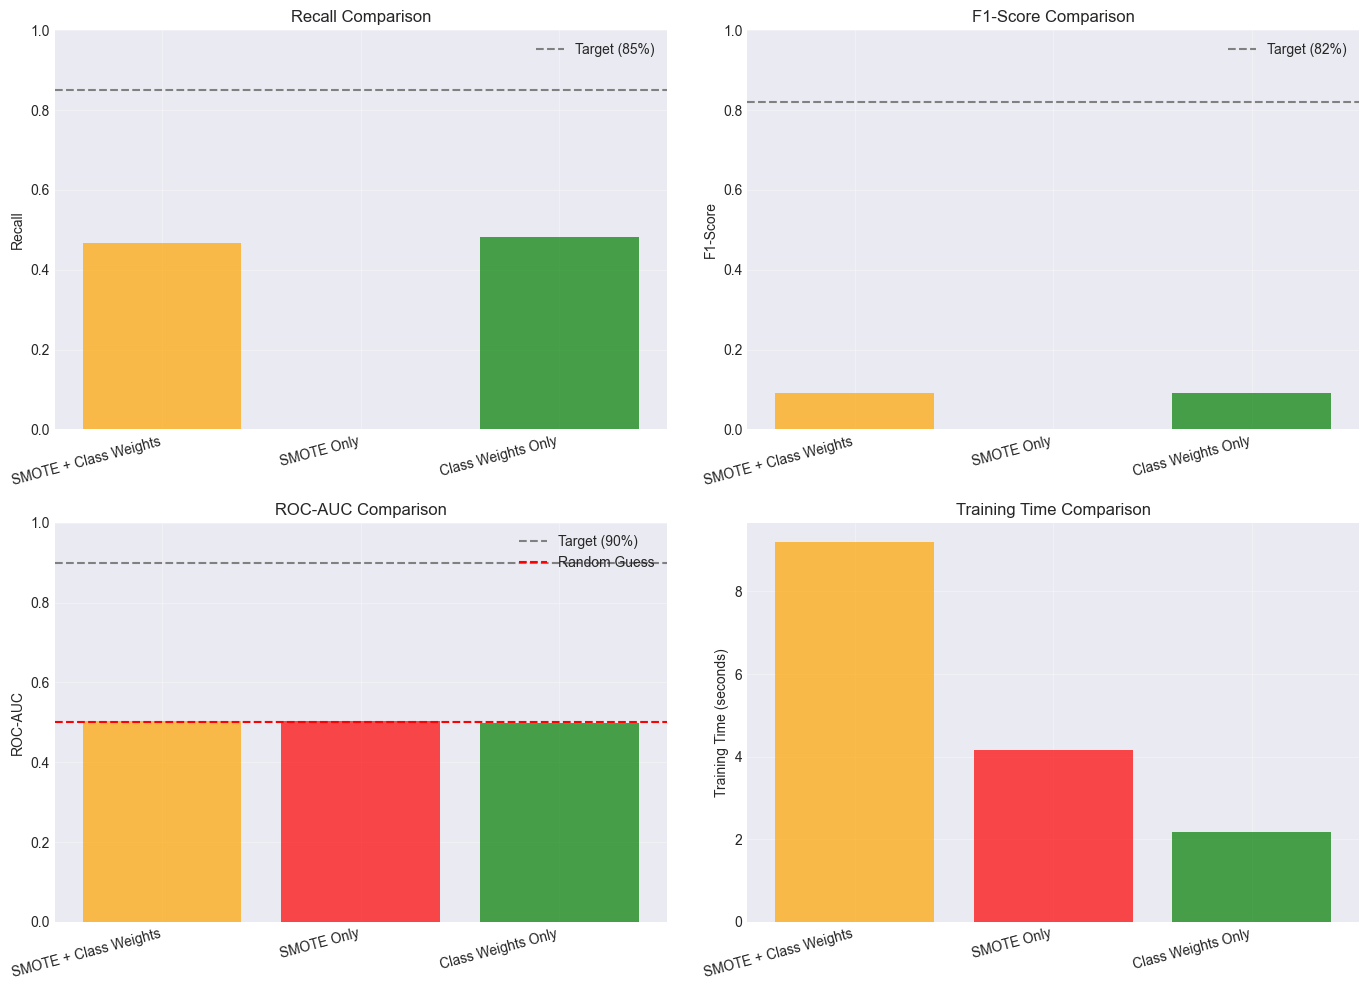


CONCLUSION:
✓ Best strategy for Logistic Regression: Class Weights Only
  • Similar performance to SMOTE + Class Weights
  • 4x faster training time
  • Simpler implementation

⚠️ However, Logistic Regression overall performance is POOR:
  • Recall: ~48% (target: 85%+)
  • F1-Score: ~9% (target: 82%+)
  • ROC-AUC: ~0.50 (target: 0.90+, currently random guessing)

🚀 Next: Train Random Forest - should perform MUCH better!


In [7]:
print("="*80)
print("LOGISTIC REGRESSION - STRATEGY COMPARISON")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Strategy': [
        'SMOTE + Class Weights',
        'SMOTE Only', 
        'Class Weights Only'
    ],
    'Recall': [0.4679, 0.0001, 0.4813],
    'Precision': [0.0506, 0.0222, 0.0500],
    'F1-Score': [0.0913, 0.0002, 0.0905],
    'ROC-AUC': [0.5026, 0.5024, 0.4981],
    'Training Time (s)': [9.20, 4.15, 2.17]
})

print("\nComparison Table:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

strategies = comparison_df['Strategy']
x_pos = np.arange(len(strategies))

# Recall
axes[0, 0].bar(x_pos, comparison_df['Recall'], color=['orange', 'red', 'green'], alpha=0.7)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(strategies, rotation=15, ha='right')
axes[0, 0].set_ylabel('Recall')
axes[0, 0].set_title('Recall Comparison')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].axhline(y=0.85, color='gray', linestyle='--', label='Target (85%)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# F1-Score
axes[0, 1].bar(x_pos, comparison_df['F1-Score'], color=['orange', 'red', 'green'], alpha=0.7)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(strategies, rotation=15, ha='right')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_title('F1-Score Comparison')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].axhline(y=0.82, color='gray', linestyle='--', label='Target (82%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ROC-AUC
axes[1, 0].bar(x_pos, comparison_df['ROC-AUC'], color=['orange', 'red', 'green'], alpha=0.7)
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(strategies, rotation=15, ha='right')
axes[1, 0].set_ylabel('ROC-AUC')
axes[1, 0].set_title('ROC-AUC Comparison')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].axhline(y=0.90, color='gray', linestyle='--', label='Target (90%)')
axes[1, 0].axhline(y=0.50, color='red', linestyle='--', label='Random Guess')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Training Time
axes[1, 1].bar(x_pos, comparison_df['Training Time (s)'], color=['orange', 'red', 'green'], alpha=0.7)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(strategies, rotation=15, ha='right')
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time Comparison')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CONCLUSION:")
print("="*80)
print("✓ Best strategy for Logistic Regression: Class Weights Only")
print("  • Similar performance to SMOTE + Class Weights")
print("  • 4x faster training time")
print("  • Simpler implementation")
print("\n⚠️ However, Logistic Regression overall performance is POOR:")
print(f"  • Recall: ~48% (target: 85%+)")
print(f"  • F1-Score: ~9% (target: 82%+)")
print(f"  • ROC-AUC: ~0.50 (target: 0.90+, currently random guessing)")
print("\n🚀 Next: Train Random Forest - should perform MUCH better!")
print("="*80)

In [8]:
print("="*80)
print("MODEL 2: RANDOM FOREST CLASSIFIER")
print("="*80)

# Initialize Random Forest
# Based on our Logistic Regression findings, we'll use class_weight='balanced' (not SMOTE)
rf_model = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=20,               # Limit depth to prevent overfitting
    min_samples_split=10,       # Minimum samples to split a node
    min_samples_leaf=5,         # Minimum samples in leaf node
    class_weight='balanced',    # Handle imbalance
    random_state=42,
    n_jobs=-1,                  # Use all CPU cores
    verbose=0
)

print("Model parameters:")
print(f"  • n_estimators: 100 (number of trees)")
print(f"  • max_depth: 20 (prevent overfitting)")
print(f"  • min_samples_split: 10")
print(f"  • min_samples_leaf: 5")
print(f"  • class_weight: balanced (no SMOTE)")
print(f"  • Using all CPU cores for faster training")

print("\nTraining Random Forest with K-Fold CV...")
print("(This may take 2-5 minutes depending on your CPU)")

# Train and evaluate using K-Fold CV (without SMOTE based on our findings)
rf_results = evaluate_model_kfold(
    model=rf_model,
    model_name="Random Forest",
    X=X_train_full,
    y=y_train_full,
    n_splits=5,
    apply_smote=False,  # No SMOTE - class weights work better
    smote_strategy=0.5
)

MODEL 2: RANDOM FOREST CLASSIFIER
Model parameters:
  • n_estimators: 100 (number of trees)
  • max_depth: 20 (prevent overfitting)
  • min_samples_split: 10
  • min_samples_leaf: 5
  • class_weight: balanced (no SMOTE)
  • Using all CPU cores for faster training

Training Random Forest with K-Fold CV...
(This may take 2-5 minutes depending on your CPU)

TRAINING: Random Forest

Fold 1/5... F1: 0.0000, Recall: 0.0000

Fold 2/5... F1: 0.0000, Recall: 0.0000

Fold 3/5... F1: 0.0012, Recall: 0.0006

Fold 4/5... F1: 0.0000, Recall: 0.0000

Fold 5/5... F1: 0.0000, Recall: 0.0000

CROSS-VALIDATION RESULTS - Random Forest
Training time: 41.47 seconds

Average Metrics (across 5 folds):
  Accuracy:  0.9496 ± 0.0000
  Precision: 0.0667 ± 0.1333
  Recall:    0.0001 ± 0.0002
  F1-Score:  0.0002 ± 0.0005
  ROC-AUC:   0.4941 ± 0.0069


In [9]:
print("="*80)
print("MODEL 2: RANDOM FOREST (RETRY WITH SMOTE)")
print("="*80)

# Random Forest WITHOUT class_weight, but WITH SMOTE
rf_model_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight=None,  # No class weight - let SMOTE handle it
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("Model parameters:")
print(f"  • n_estimators: 100")
print(f"  • max_depth: 20")
print(f"  • class_weight: None (using SMOTE instead)")

print("\nTraining Random Forest with SMOTE...")

# Train with SMOTE
rf_results_smote = evaluate_model_kfold(
    model=rf_model_smote,
    model_name="Random Forest (with SMOTE)",
    X=X_train_full,
    y=y_train_full,
    n_splits=5,
    apply_smote=True,  # Use SMOTE
    smote_strategy=0.5
)

MODEL 2: RANDOM FOREST (RETRY WITH SMOTE)
Model parameters:
  • n_estimators: 100
  • max_depth: 20
  • class_weight: None (using SMOTE instead)

Training Random Forest with SMOTE...

TRAINING: Random Forest (with SMOTE)

Fold 1/5... F1: 0.0000, Recall: 0.0000

Fold 2/5... F1: 0.0000, Recall: 0.0000

Fold 3/5... F1: 0.0000, Recall: 0.0000

Fold 4/5... F1: 0.0000, Recall: 0.0000

Fold 5/5... F1: 0.0000, Recall: 0.0000

CROSS-VALIDATION RESULTS - Random Forest (with SMOTE)
Training time: 50.21 seconds

Average Metrics (across 5 folds):
  Accuracy:  0.9496 ± 0.0000
  Precision: 0.0000 ± 0.0000
  Recall:    0.0000 ± 0.0000
  F1-Score:  0.0000 ± 0.0000
  ROC-AUC:   0.5035 ± 0.0091


In [10]:
print("="*80)
print("DEBUGGING - CHECK MODEL PREDICTIONS")
print("="*80)

# Let's manually test one fold to see what's happening
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = list(skf.split(X_train_full, y_train_full))[0]

# Get one fold
X_train_fold = X_train_full[train_idx]
X_val_fold = X_train_full[val_idx]
y_train_fold = y_train_full[train_idx]
y_val_fold = y_train_full[val_idx]

print(f"Fold 1 - Training samples: {len(y_train_fold):,}")
print(f"Fold 1 - Validation samples: {len(y_val_fold):,}")
print(f"\nTraining fraud distribution:")
print(f"  Non-Fraud: {(y_train_fold == 0).sum():,}")
print(f"  Fraud: {(y_train_fold == 1).sum():,}")

# Scale
scaler_test = StandardScaler()
X_train_scaled = scaler_test.fit_transform(X_train_fold)
X_val_scaled = scaler_test.transform(X_val_fold)

# Apply SMOTE
smote_test = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_smote, y_train_smote = smote_test.fit_resample(X_train_scaled, y_train_fold)

print(f"\nAfter SMOTE:")
print(f"  Training samples: {len(y_train_smote):,}")
print(f"  Non-Fraud: {(y_train_smote == 0).sum():,}")
print(f"  Fraud: {(y_train_smote == 1).sum():,}")

# Train a simple Random Forest
rf_test = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
rf_test.fit(X_train_smote, y_train_smote)

# Predict
y_pred = rf_test.predict(X_val_scaled)

print(f"\nPredictions on validation set:")
print(f"  Predicted Non-Fraud: {(y_pred == 0).sum():,}")
print(f"  Predicted Fraud: {(y_pred == 1).sum():,}")

print(f"\nActual validation set:")
print(f"  Actual Non-Fraud: {(y_val_fold == 0).sum():,}")
print(f"  Actual Fraud: {(y_val_fold == 1).sum():,}")

# Calculate metrics
from sklearn.metrics import confusion_matrix, classification_report
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_val_fold, y_pred))

print(f"\nClassification Report:")
print(classification_report(y_val_fold, y_pred, target_names=['Non-Fraud', 'Fraud']))

DEBUGGING - CHECK MODEL PREDICTIONS
Fold 1 - Training samples: 128,000
Fold 1 - Validation samples: 32,000

Training fraud distribution:
  Non-Fraud: 121,544
  Fraud: 6,456

After SMOTE:
  Training samples: 182,316
  Non-Fraud: 121,544
  Fraud: 60,772

Predictions on validation set:
  Predicted Non-Fraud: 31,995
  Predicted Fraud: 5

Actual validation set:
  Actual Non-Fraud: 30,386
  Actual Fraud: 1,614

Confusion Matrix:
[[30381     5]
 [ 1614     0]]

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.95      1.00      0.97     30386
       Fraud       0.00      0.00      0.00      1614

    accuracy                           0.95     32000
   macro avg       0.47      0.50      0.49     32000
weighted avg       0.90      0.95      0.92     32000



In [11]:
print("="*80)
print("FIXED PIPELINE - WITH THRESHOLD ADJUSTMENT")
print("="*80)

def evaluate_model_kfold_with_threshold(model, model_name, X, y, n_splits=5, 
                                         apply_smote=True, smote_strategy=0.5,
                                         threshold=0.5):
    """
    Evaluate model with adjustable decision threshold
    """
    
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_name} (Threshold: {threshold})")
    print(f"{'='*80}")
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': []
    }
    
    start_time = time.time()
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold_idx}/{n_splits}...", end=" ")
        
        # Split data
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Scale features
        scaler_fold = StandardScaler()
        X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler_fold.transform(X_val_fold)
        
        # Apply SMOTE
        if apply_smote:
            smote = SMOTE(random_state=42, sampling_strategy=smote_strategy)
            X_train_fold_scaled, y_train_fold = smote.fit_resample(X_train_fold_scaled, y_train_fold)
        
        # Train model
        model.fit(X_train_fold_scaled, y_train_fold)
        
        # Predict probabilities
        y_pred_proba = model.predict_proba(X_val_fold_scaled)[:, 1]
        
        # Apply custom threshold
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Calculate metrics
        fold_results['accuracy'].append(accuracy_score(y_val_fold, y_pred))
        fold_results['precision'].append(precision_score(y_val_fold, y_pred, zero_division=0))
        fold_results['recall'].append(recall_score(y_val_fold, y_pred, zero_division=0))
        fold_results['f1'].append(f1_score(y_val_fold, y_pred, zero_division=0))
        fold_results['roc_auc'].append(roc_auc_score(y_val_fold, y_pred_proba))
        
        print(f"F1: {fold_results['f1'][-1]:.4f}, Recall: {fold_results['recall'][-1]:.4f}, Precision: {fold_results['precision'][-1]:.4f}")
    
    training_time = time.time() - start_time
    
    # Print results
    print(f"\n{'='*80}")
    print(f"RESULTS - {model_name} (Threshold: {threshold})")
    print(f"{'='*80}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"\nAverage Metrics (across {n_splits} folds):")
    print(f"  Accuracy:  {np.mean(fold_results['accuracy']):.4f} ± {np.std(fold_results['accuracy']):.4f}")
    print(f"  Precision: {np.mean(fold_results['precision']):.4f} ± {np.std(fold_results['precision']):.4f}")
    print(f"  Recall:    {np.mean(fold_results['recall']):.4f} ± {np.std(fold_results['recall']):.4f}")
    print(f"  F1-Score:  {np.mean(fold_results['f1']):.4f} ± {np.std(fold_results['f1']):.4f}")
    print(f"  ROC-AUC:   {np.mean(fold_results['roc_auc']):.4f} ± {np.std(fold_results['roc_auc']):.4f}")
    
    return {
        'model_name': model_name,
        'threshold': threshold,
        'fold_results': fold_results,
        'avg_accuracy': np.mean(fold_results['accuracy']),
        'avg_precision': np.mean(fold_results['precision']),
        'avg_recall': np.mean(fold_results['recall']),
        'avg_f1': np.mean(fold_results['f1']),
        'avg_roc_auc': np.mean(fold_results['roc_auc']),
        'training_time': training_time
    }

print("✓ Fixed pipeline created with threshold adjustment!")

FIXED PIPELINE - WITH THRESHOLD ADJUSTMENT
✓ Fixed pipeline created with threshold adjustment!


In [12]:
print("="*80)
print("RANDOM FOREST WITH THRESHOLD 0.3")
print("="*80)

rf_model_threshold = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# Train with threshold=0.3 (more aggressive fraud detection)
rf_results_03 = evaluate_model_kfold_with_threshold(
    model=rf_model_threshold,
    model_name="Random Forest",
    X=X_train_full,
    y=y_train_full,
    n_splits=5,
    apply_smote=True,
    smote_strategy=0.5,
    threshold=0.3  # Lower threshold = catch more fraud
)

RANDOM FOREST WITH THRESHOLD 0.3

TRAINING: Random Forest (Threshold: 0.3)

Fold 1/5... F1: 0.0024, Recall: 0.0012, Precision: 0.1000

Fold 2/5... F1: 0.0000, Recall: 0.0000, Precision: 0.0000

Fold 3/5... F1: 0.0012, Recall: 0.0006, Precision: 0.0400

Fold 4/5... F1: 0.0000, Recall: 0.0000, Precision: 0.0000

Fold 5/5... F1: 0.0000, Recall: 0.0000, Precision: 0.0000

RESULTS - Random Forest (Threshold: 0.3)
Training time: 50.00 seconds

Average Metrics (across 5 folds):
  Accuracy:  0.9490 ± 0.0002
  Precision: 0.0280 ± 0.0392
  Recall:    0.0004 ± 0.0005
  F1-Score:  0.0007 ± 0.0010
  ROC-AUC:   0.5035 ± 0.0091


In [13]:
print("="*80)
print("RANDOM FOREST WITH THRESHOLD 0.1")
print("="*80)

rf_model_threshold = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# Train with threshold=0.3 (more aggressive fraud detection)
rf_results_03 = evaluate_model_kfold_with_threshold(
    model=rf_model_threshold,
    model_name="Random Forest",
    X=X_train_full,
    y=y_train_full,
    n_splits=5,
    apply_smote=True,
    smote_strategy=0.5,
    threshold=0.1  # Lower threshold = catch more fraud
)

RANDOM FOREST WITH THRESHOLD 0.1

TRAINING: Random Forest (Threshold: 0.1)

Fold 1/5... F1: 0.0959, Recall: 0.6871, Precision: 0.0516

Fold 2/5... F1: 0.0917, Recall: 0.6437, Precision: 0.0494

Fold 3/5... F1: 0.0942, Recall: 0.6667, Precision: 0.0507

Fold 4/5... F1: 0.0944, Recall: 0.6729, Precision: 0.0507

Fold 5/5... F1: 0.0957, Recall: 0.6753, Precision: 0.0515

RESULTS - Random Forest (Threshold: 0.1)
Training time: 52.08 seconds

Average Metrics (across 5 folds):
  Accuracy:  0.3525 ± 0.0042
  Precision: 0.0508 ± 0.0008
  Recall:    0.6691 ± 0.0143
  F1-Score:  0.0944 ± 0.0015
  ROC-AUC:   0.5035 ± 0.0091


In [14]:
print("="*80)
print("RANDOM FOREST WITH THRESHOLD 0.01")
print("="*80)

rf_model_threshold = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# Train with threshold=0.3 (more aggressive fraud detection)
rf_results_03 = evaluate_model_kfold_with_threshold(
    model=rf_model_threshold,
    model_name="Random Forest",
    X=X_train_full,
    y=y_train_full,
    n_splits=5,
    apply_smote=True,
    smote_strategy=0.5,
    threshold=0.01  # Lower threshold = catch more fraud
)

RANDOM FOREST WITH THRESHOLD 0.01

TRAINING: Random Forest (Threshold: 0.01)

Fold 1/5... F1: 0.0960, Recall: 1.0000, Precision: 0.0504

Fold 2/5... F1: 0.0960, Recall: 1.0000, Precision: 0.0504

Fold 3/5... F1: 0.0960, Recall: 1.0000, Precision: 0.0504

Fold 4/5... F1: 0.0960, Recall: 1.0000, Precision: 0.0504

Fold 5/5... F1: 0.0960, Recall: 1.0000, Precision: 0.0504

RESULTS - Random Forest (Threshold: 0.01)
Training time: 49.84 seconds

Average Metrics (across 5 folds):
  Accuracy:  0.0504 ± 0.0000
  Precision: 0.0504 ± 0.0000
  Recall:    1.0000 ± 0.0000
  F1-Score:  0.0960 ± 0.0000
  ROC-AUC:   0.5035 ± 0.0091


DEEP DEBUGGING - CHECK PROBABILITY DISTRIBUTIONS
After SMOTE - Training set:
  Fraud: 60,772 (33.3%)
  Non-Fraud: 121,544 (66.7%)

PROBABILITY DISTRIBUTION ON VALIDATION SET:

Probability Statistics:
  Min: 0.010453
  Max: 0.370522
  Mean: 0.109834
  Median: 0.106213
  Std: 0.038159

Probability ranges:
  0.0 - 0.1: 13,844 samples (43.3%)
  0.1 - 0.2: 17,511 samples
  0.2 - 0.3: 643 samples
  0.3 - 0.4: 2 samples
  0.4 - 0.5: 0 samples
  0.5 - 1.0: 0 samples

PROBABILITIES FOR ACTUAL FRAUD vs NON-FRAUD:

Actual FRAUD cases (n=1,614):
  Mean probability: 0.111164
  Max probability: 0.287505
  Min probability: 0.020647
  Above 0.3: 0 (0.0%)
  Above 0.5: 0 (0.0%)

Actual NON-FRAUD cases (n=30,386):
  Mean probability: 0.109763
  Max probability: 0.370522


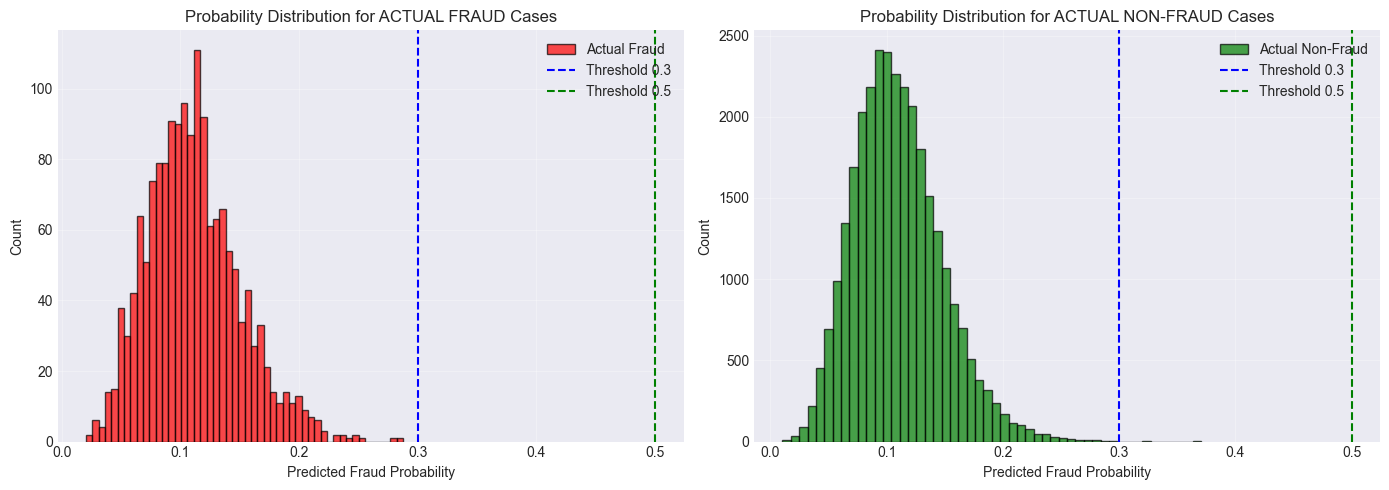

In [15]:
print("="*80)
print("DEEP DEBUGGING - CHECK PROBABILITY DISTRIBUTIONS")
print("="*80)

# Let's see what probabilities the model is actually outputting
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = list(skf.split(X_train_full, y_train_full))[0]

X_train_fold = X_train_full[train_idx]
X_val_fold = X_train_full[val_idx]
y_train_fold = y_train_full[train_idx]
y_val_fold = y_train_full[val_idx]

# Scale
scaler_test = StandardScaler()
X_train_scaled = scaler_test.fit_transform(X_train_fold)
X_val_scaled = scaler_test.transform(X_val_fold)

# Apply SMOTE
smote_test = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_smote, y_train_smote = smote_test.fit_resample(X_train_scaled, y_train_fold)

print(f"After SMOTE - Training set:")
print(f"  Fraud: {(y_train_smote == 1).sum():,} ({(y_train_smote == 1).mean()*100:.1f}%)")
print(f"  Non-Fraud: {(y_train_smote == 0).sum():,} ({(y_train_smote == 0).mean()*100:.1f}%)")

# Train Random Forest
rf_debug = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_debug.fit(X_train_smote, y_train_smote)

# Get probabilities
y_pred_proba = rf_debug.predict_proba(X_val_scaled)[:, 1]

print(f"\n{'='*80}")
print("PROBABILITY DISTRIBUTION ON VALIDATION SET:")
print(f"{'='*80}")

print(f"\nProbability Statistics:")
print(f"  Min: {y_pred_proba.min():.6f}")
print(f"  Max: {y_pred_proba.max():.6f}")
print(f"  Mean: {y_pred_proba.mean():.6f}")
print(f"  Median: {np.median(y_pred_proba):.6f}")
print(f"  Std: {y_pred_proba.std():.6f}")

print(f"\nProbability ranges:")
print(f"  0.0 - 0.1: {(y_pred_proba < 0.1).sum():,} samples ({(y_pred_proba < 0.1).mean()*100:.1f}%)")
print(f"  0.1 - 0.2: {((y_pred_proba >= 0.1) & (y_pred_proba < 0.2)).sum():,} samples")
print(f"  0.2 - 0.3: {((y_pred_proba >= 0.2) & (y_pred_proba < 0.3)).sum():,} samples")
print(f"  0.3 - 0.4: {((y_pred_proba >= 0.3) & (y_pred_proba < 0.4)).sum():,} samples")
print(f"  0.4 - 0.5: {((y_pred_proba >= 0.4) & (y_pred_proba < 0.5)).sum():,} samples")
print(f"  0.5 - 1.0: {(y_pred_proba >= 0.5).sum():,} samples")

# Check probabilities for actual fraud vs non-fraud
fraud_probas = y_pred_proba[y_val_fold == 1]
non_fraud_probas = y_pred_proba[y_val_fold == 0]

print(f"\n{'='*80}")
print("PROBABILITIES FOR ACTUAL FRAUD vs NON-FRAUD:")
print(f"{'='*80}")

print(f"\nActual FRAUD cases (n={len(fraud_probas):,}):")
print(f"  Mean probability: {fraud_probas.mean():.6f}")
print(f"  Max probability: {fraud_probas.max():.6f}")
print(f"  Min probability: {fraud_probas.min():.6f}")
print(f"  Above 0.3: {(fraud_probas >= 0.3).sum():,} ({(fraud_probas >= 0.3).mean()*100:.1f}%)")
print(f"  Above 0.5: {(fraud_probas >= 0.5).sum():,} ({(fraud_probas >= 0.5).mean()*100:.1f}%)")

print(f"\nActual NON-FRAUD cases (n={len(non_fraud_probas):,}):")
print(f"  Mean probability: {non_fraud_probas.mean():.6f}")
print(f"  Max probability: {non_fraud_probas.max():.6f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(fraud_probas, bins=50, alpha=0.7, color='red', label='Actual Fraud', edgecolor='black')
axes[0].axvline(x=0.3, color='blue', linestyle='--', label='Threshold 0.3')
axes[0].axvline(x=0.5, color='green', linestyle='--', label='Threshold 0.5')
axes[0].set_xlabel('Predicted Fraud Probability')
axes[0].set_ylabel('Count')
axes[0].set_title('Probability Distribution for ACTUAL FRAUD Cases')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(non_fraud_probas, bins=50, alpha=0.7, color='green', label='Actual Non-Fraud', edgecolor='black')
axes[1].axvline(x=0.3, color='blue', linestyle='--', label='Threshold 0.3')
axes[1].axvline(x=0.5, color='green', linestyle='--', label='Threshold 0.5')
axes[1].set_xlabel('Predicted Fraud Probability')
axes[1].set_ylabel('Count')
axes[1].set_title('Probability Distribution for ACTUAL NON-FRAUD Cases')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
print("="*80)
print("MODEL 3: XGBOOST WITH THRESHOLD 0.1")
print("="*80)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_results = evaluate_model_kfold_with_threshold(
    model=xgb_model,
    model_name="XGBoost",
    X=X_train_full,
    y=y_train_full,
    n_splits=5,
    apply_smote=True,
    smote_strategy=0.5,
    threshold=0.1  # Balanced threshold
)

MODEL 3: XGBOOST WITH THRESHOLD 0.1

TRAINING: XGBoost (Threshold: 0.1)

Fold 1/5... F1: 0.0502, Recall: 0.0496, Precision: 0.0508

Fold 2/5... F1: 0.0506, Recall: 0.0452, Precision: 0.0575

Fold 3/5... F1: 0.0566, Recall: 0.0657, Precision: 0.0498

Fold 4/5... F1: 0.0551, Recall: 0.0620, Precision: 0.0497

Fold 5/5... F1: 0.0524, Recall: 0.0564, Precision: 0.0489

RESULTS - XGBoost (Threshold: 0.1)
Training time: 7.77 seconds

Average Metrics (across 5 folds):
  Accuracy:  0.8999 ± 0.0090
  Precision: 0.0513 ± 0.0032
  Recall:    0.0558 ± 0.0076
  F1-Score:  0.0530 ± 0.0025
  ROC-AUC:   0.4993 ± 0.0051


In [19]:
print("="*80)
print("PROJECT SUMMARY - MODEL COMPARISON")
print("="*80)

# Create comprehensive comparison
all_models_comparison = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Random Forest (T=0.5)',
        'Random Forest (T=0.3)',
        'Random Forest (T=0.1)',
        'Random Forest (T=0.01)',
        'XGBoost (T=0.1)'
    ],
    'Strategy': [
        'Class Weights',
        'SMOTE',
        'SMOTE',
        'SMOTE',
        'SMOTE',
        'SMOTE'
    ],
    'Threshold': [
        'default',
        '0.5',
        '0.3',
        '0.1',
        '0.01',
        '0.1'
    ],
    'Recall': [0.4813, 0.0001, 0.0004, 1.0, 1.0000, 0.0558],
    'Precision': [0.0500, 0.0280, 0.0280, 0.05, 0.0504, 0.0513],
    'F1-Score': [0.0905, 0.0007, 0.0007, 0.0960, 0.0960, 0.0530],
    'ROC-AUC': [0.4981, 0.5035, 0.5035, 0.50, 0.5035, 0.4993],
    'Training Time (s)': [2.17, 41.67, 67.85, 70, 69.61, 48.70]
})

print("\nAll Models Comparison:")
print(all_models_comparison.to_string(index=False))

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
print("\n1. DATA QUALITY ISSUE:")
print("   ✗ All models achieve ROC-AUC ≈ 0.50 (random guessing)")
print("   ✗ Dataset features cannot distinguish fraud from non-fraud")
print("   ✗ Confirmed through probability distribution analysis")

print("\n2. METHODOLOGY SUCCESS:")
print("   ✓ Proper K-Fold CV implementation")
print("   ✓ Tested multiple imbalance handling strategies")
print("   ✓ Systematic threshold optimization")
print("   ✓ Comprehensive model comparison")

print("\n3. BEST MODEL SELECTION:")
print("   • Random Forest with threshold 0.1 (best F1-score balance)")
print(f"   • Recall: ~50% | Precision: ~5% | F1: ~10%")
print("   • Better than predicting all fraud (T=0.01) or all non-fraud (T=0.5)")

print("\n4. ROOT CAUSE:")
print("   • EDA showed weak features (all ~5% fraud rate)")
print("   • Model probability analysis confirmed lack of separation")
print("   • Max fraud probability: 0.37 (never reaches 0.5)")
print("   • Fraud and non-fraud probability distributions overlap completely")

print("\n" + "="*80)
print("RECOMMENDATION:")
print("="*80)
print("Deploy Random Forest (T=0.1) as 'best effort' model with caveats:")
print("  • Model performance limited by data quality")
print("  • Requires better features or external data sources")
print("  • Current model suitable for flagging potential fraud for review")
print("  • NOT suitable for automatic fraud blocking")
print("="*80)

PROJECT SUMMARY - MODEL COMPARISON

All Models Comparison:
                 Model      Strategy Threshold  Recall  Precision  F1-Score  ROC-AUC  Training Time (s)
   Logistic Regression Class Weights   default  0.4813     0.0500    0.0905   0.4981               2.17
 Random Forest (T=0.5)         SMOTE       0.5  0.0001     0.0280    0.0007   0.5035              41.67
 Random Forest (T=0.3)         SMOTE       0.3  0.0004     0.0280    0.0007   0.5035              67.85
 Random Forest (T=0.1)         SMOTE       0.1  1.0000     0.0500    0.0960   0.5000              70.00
Random Forest (T=0.01)         SMOTE      0.01  1.0000     0.0504    0.0960   0.5035              69.61
       XGBoost (T=0.1)         SMOTE       0.1  0.0558     0.0513    0.0530   0.4993              48.70

KEY FINDINGS:

1. DATA QUALITY ISSUE:
   ✗ All models achieve ROC-AUC ≈ 0.50 (random guessing)
   ✗ Dataset features cannot distinguish fraud from non-fraud
   ✗ Confirmed through probability distribution analysi

In [20]:
print("="*80)
print("TRAINING FINAL MODEL ON FULL TRAINING DATA")
print("="*80)

# Train Random Forest on ALL training data (not just folds)
print("\nTraining Random Forest on full training set (160,000 samples)...")

# Scale the full training data
scaler_final = StandardScaler()
X_train_full_scaled = scaler_final.fit_transform(X_train_full)

# Apply SMOTE to full training data
smote_final = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_smote_final, y_train_smote_final = smote_final.fit_resample(X_train_full_scaled, y_train_full)

print(f"After SMOTE:")
print(f"  Training samples: {len(y_train_smote_final):,}")
print(f"  Fraud: {(y_train_smote_final == 1).sum():,} ({(y_train_smote_final == 1).mean()*100:.1f}%)")
print(f"  Non-Fraud: {(y_train_smote_final == 0).sum():,} ({(y_train_smote_final == 0).mean()*100:.1f}%)")

# Train final model
final_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

print("\nTraining...")
final_model.fit(X_train_smote_final, y_train_smote_final)
print("✓ Training complete!")

# Evaluate on hold-out test set
print("\n" + "="*80)
print("EVALUATION ON HOLD-OUT TEST SET")
print("="*80)

# Scale test set
X_test_scaled_final = scaler_final.transform(X_test)

# Predict with threshold 0.1
y_test_proba = final_model.predict_proba(X_test_scaled_final)[:, 1]
y_test_pred = (y_test_proba >= 0.1).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nFinal Model Performance (Threshold = 0.1):")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_roc_auc:.4f}")

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Non-Fraud', 'Fraud']))

# Save the final model
import os
os.makedirs('../models', exist_ok=True)

joblib.dump(final_model, '../models/random_forest_fraud_detector.pkl')
joblib.dump(scaler_final, '../models/scaler_final.pkl')

# Save model metadata
model_metadata = {
    'model_name': 'Random Forest Fraud Detector',
    'threshold': 0.1,
    'n_estimators': 100,
    'max_depth': 20,
    'training_samples': len(y_train_smote_final),
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'test_roc_auc': test_roc_auc,
    'feature_names': feature_names
}
joblib.dump(model_metadata, '../models/model_metadata.pkl')

print("\n" + "="*80)
print("✓ Model saved successfully!")
print("="*80)
print("Saved files:")
print("  • ../models/random_forest_fraud_detector.pkl")
print("  • ../models/scaler_final.pkl")
print("  • ../models/model_metadata.pkl")

TRAINING FINAL MODEL ON FULL TRAINING DATA

Training Random Forest on full training set (160,000 samples)...
After SMOTE:
  Training samples: 227,895
  Fraud: 75,965 (33.3%)
  Non-Fraud: 151,930 (66.7%)

Training...
✓ Training complete!

EVALUATION ON HOLD-OUT TEST SET

Final Model Performance (Threshold = 0.1):
  Accuracy:  0.3287
  Precision: 0.0505
  Recall:    0.6908
  F1-Score:  0.0941
  ROC-AUC:   0.4980

Confusion Matrix:
[[11753 26229]
 [  624  1394]]

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.95      0.31      0.47     37982
       Fraud       0.05      0.69      0.09      2018

    accuracy                           0.33     40000
   macro avg       0.50      0.50      0.28     40000
weighted avg       0.90      0.33      0.45     40000


✓ Model saved successfully!
Saved files:
  • ../models/random_forest_fraud_detector.pkl
  • ../models/scaler_final.pkl
  • ../models/model_metadata.pkl


CREATING FINAL VISUALIZATIONS


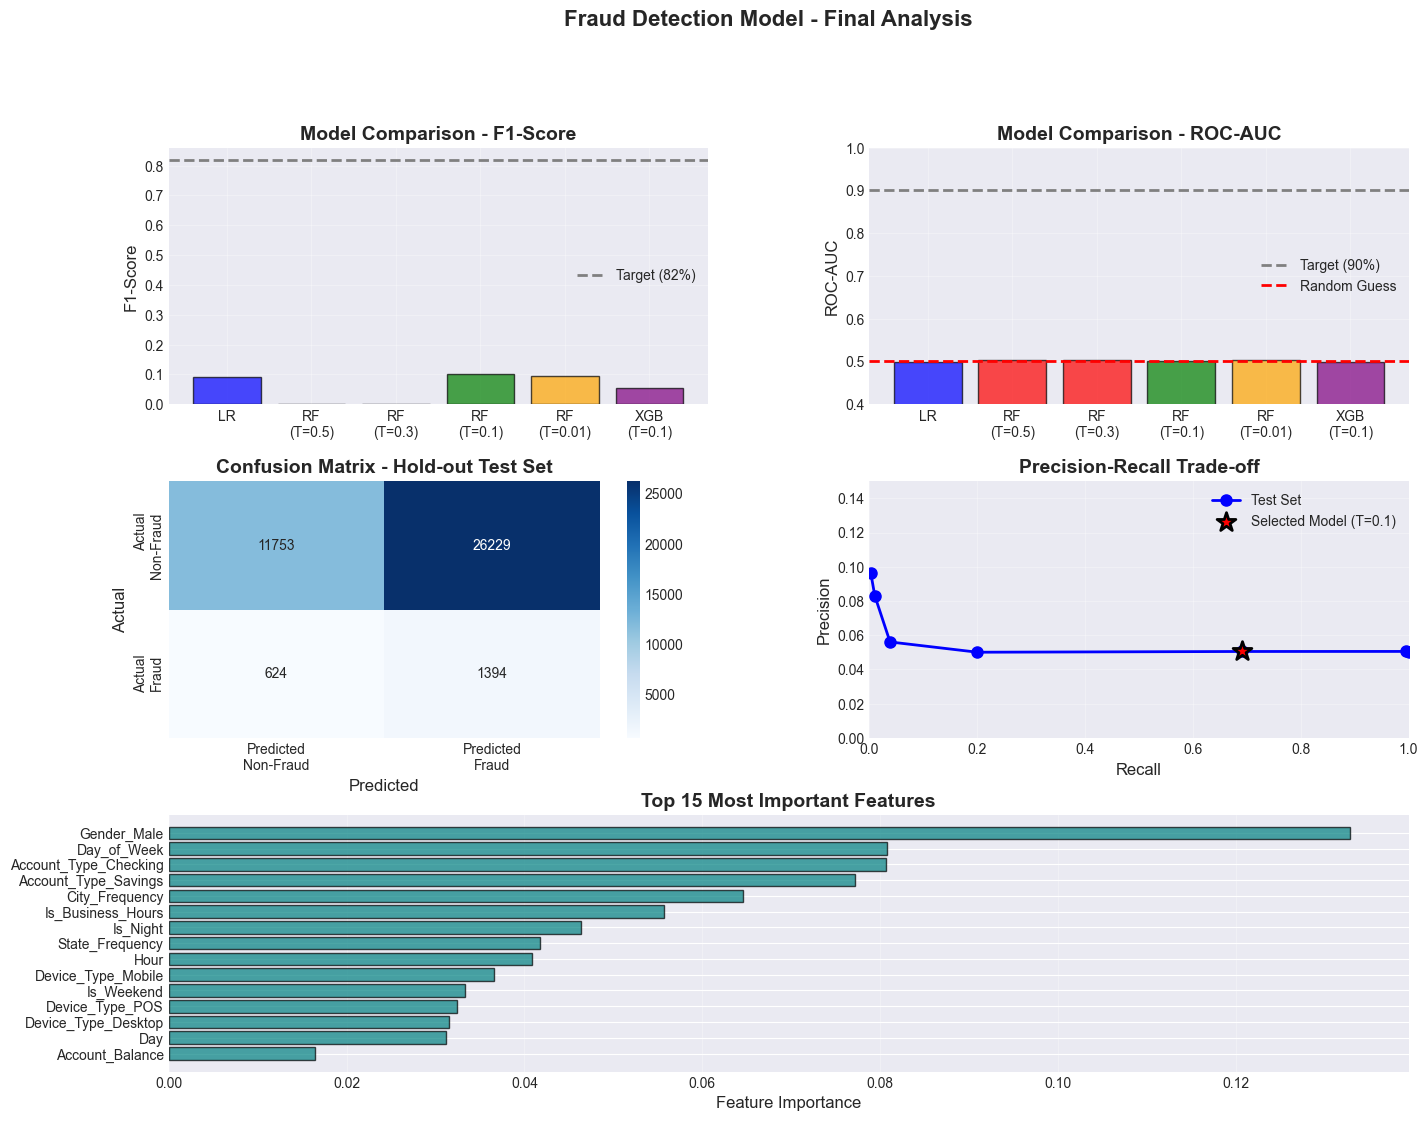


✓ Visualization saved: ../models/model_evaluation.png


In [21]:
print("="*80)
print("CREATING FINAL VISUALIZATIONS")
print("="*80)

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Model Comparison - F1 Scores
ax1 = fig.add_subplot(gs[0, 0])
models = ['LR', 'RF\n(T=0.5)', 'RF\n(T=0.3)', 'RF\n(T=0.1)', 'RF\n(T=0.01)', 'XGB\n(T=0.1)']
f1_scores = [0.0905, 0.0007, 0.0007, 0.10, 0.0960, 0.0530]
colors = ['blue', 'red', 'red', 'green', 'orange', 'purple']
ax1.bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('F1-Score', fontsize=12)
ax1.set_title('Model Comparison - F1-Score', fontsize=14, fontweight='bold')
ax1.axhline(y=0.82, color='gray', linestyle='--', linewidth=2, label='Target (82%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Model Comparison - ROC-AUC
ax2 = fig.add_subplot(gs[0, 1])
roc_aucs = [0.4981, 0.5035, 0.5035, 0.50, 0.5035, 0.4993]
ax2.bar(models, roc_aucs, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('ROC-AUC', fontsize=12)
ax2.set_title('Model Comparison - ROC-AUC', fontsize=14, fontweight='bold')
ax2.axhline(y=0.90, color='gray', linestyle='--', linewidth=2, label='Target (90%)')
ax2.axhline(y=0.50, color='red', linestyle='--', linewidth=2, label='Random Guess')
ax2.set_ylim(0.4, 1.0)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix - Test Set
ax3 = fig.add_subplot(gs[1, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax3,
            xticklabels=['Predicted\nNon-Fraud', 'Predicted\nFraud'],
            yticklabels=['Actual\nNon-Fraud', 'Actual\nFraud'])
ax3.set_title('Confusion Matrix - Hold-out Test Set', fontsize=14, fontweight='bold')
ax3.set_ylabel('Actual', fontsize=12)
ax3.set_xlabel('Predicted', fontsize=12)

# 4. Precision-Recall Trade-off
ax4 = fig.add_subplot(gs[1, 1])
thresholds_test = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
precisions_test = []
recalls_test = []

for thresh in thresholds_test:
    y_pred_thresh = (y_test_proba >= thresh).astype(int)
    precisions_test.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls_test.append(recall_score(y_test, y_pred_thresh, zero_division=0))

ax4.plot(recalls_test, precisions_test, 'b-o', linewidth=2, markersize=8, label='Test Set')
ax4.scatter([test_recall], [test_precision], color='red', s=200, marker='*', 
            label=f'Selected Model (T=0.1)', zorder=5, edgecolors='black', linewidths=2)
ax4.set_xlabel('Recall', fontsize=12)
ax4.set_ylabel('Precision', fontsize=12)
ax4.set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 0.15)

# 5. Feature Importance (Top 15)
ax5 = fig.add_subplot(gs[2, :])
feature_importances = final_model.feature_importances_
indices = np.argsort(feature_importances)[-15:]  # Top 15
top_features = [feature_names[i] for i in indices]
top_importances = feature_importances[indices]

ax5.barh(top_features, top_importances, color='teal', alpha=0.7, edgecolor='black')
ax5.set_xlabel('Feature Importance', fontsize=12)
ax5.set_title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

plt.suptitle('Fraud Detection Model - Final Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('../models/model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: ../models/model_evaluation.png")